In [ ]:
!pip install coral_pytorch transformers datasets torch scikit-learn accelerate

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, cohen_kappa_score, mean_absolute_error, mean_squared_error
from transformers import (
    AutoTokenizer,
    AutoModel,
    PreTrainedModel,
    PretrainedConfig,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import Dataset
from coral_pytorch.layers import CoralLayer
from coral_pytorch.losses import CoralLoss
from transformers import EarlyStoppingCallback

In [ ]:
MODEL_NAME = "xlm-roberta-base"
N_FOLDS = 5
MAX_LEN = 512
BATCH_SIZE = 8
EPOCHS = 6          
NUM_CLASSES = 8

In [ ]:
class XLMRCoralOrdinal(nn.Module):
    """
    Custom XLM-RoBERTa Model with CORAL Head.
    We wrap it in nn.Module so Trainer can use it.
    """
    def __init__(self, model_name, num_classes):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden_size = self.encoder.config.hidden_size

        # CORAL Layer: Projects hidden_size -> 1 scalar, with (num_classes-1) biases
        self.coral = CoralLayer(hidden_size, num_classes)
        self.loss_fn = CoralLoss()

    def forward(self, input_ids, attention_mask, labels=None, **kwargs):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        # Use CLS token (index 0)
        pooled = outputs.last_hidden_state[:, 0, :]

        # 2. CORAL Projection
        # logits shape: [Batch, Num_Classes-1]
        logits = self.coral(pooled)

        loss = None
        if labels is not None:
            # CORAL Loss expects floating point binary vectors
            loss = self.loss_fn(logits, labels.float())

        # Return dictionary as expected by Trainer
        return {"loss": loss, "logits": logits} if loss is not None else {"logits": logits}

In [ ]:
df = pd.read_csv('training_data.csv')

In [ ]:
if df['labels'].min() == 1:
    print("Shifting labels from 1-8 to 0-7...")
    df['labels'] = df['labels'] - 1

df['labels'] = df['labels'].astype(int)

Shifting labels from 1-8 to 0-7...


In [ ]:
print("Unique labels found:", df['labels'].unique())
print("Min label:", df['labels'].min())
print("Max label:", df['labels'].max())

Unique labels found: [4 3 1 5 2 6 0 7]
Min label: 0
Max label: 7


In [ ]:
def label_to_levels(label, num_classes):
    return [1.0]*label + [0.0]*(num_classes - 1 - label)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=MAX_LEN)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [ ]:
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
fold_metrics = {'accuracy': [], 'qwk': [], 'mae': [], 'rmse': []}

best_score = -float('inf')
best_model_dir = "./best_essay_model"

print(f"Starting {N_FOLDS}-Fold CV (CORAL Ordinal)...")

Starting 5-Fold CV (CORAL Ordinal)...


In [ ]:
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['labels'])):
    print(f"\n{'='*20} FOLD {fold+1}/{N_FOLDS} {'='*20}")

    train_df = df.iloc[train_idx].copy()
    val_df = df.iloc[val_idx].copy()

    train_ds = Dataset.from_pandas(train_df)
    val_ds = Dataset.from_pandas(val_df)

    # Apply CORAL Encoding (Overwrite 'labels' with vector)
    # We do this AFTER split so we can use integers for StratifiedKFold
    train_ds = train_ds.map(lambda x: {'labels': label_to_levels(x['labels'], NUM_CLASSES)})
    val_ds = val_ds.map(lambda x: {'labels': label_to_levels(x['labels'], NUM_CLASSES)})


    train_tokenized = train_ds.map(tokenize_function, batched=True)
    val_tokenized = val_ds.map(tokenize_function, batched=True)


    model = XLMRCoralOrdinal(MODEL_NAME, NUM_CLASSES)

    def compute_metrics(eval_pred):
        logits, labels = eval_pred

        # 1. Recovering True Label (Sum of 1s)
        # Ex: [1, 1, 0] -> 2
        true_vals = np.sum(labels, axis=-1)

        # 2. Recovering Pred Label (Sum of Probabilities > 0.5)
        # Sigmoid to get 0-1 probs
        probs = 1 / (1 + np.exp(-logits))

        pred_vals = np.sum(probs, axis=-1)
        pred_int = np.round(pred_vals).astype(int)


        acc = accuracy_score(true_vals, pred_int)
        qwk = cohen_kappa_score(true_vals, pred_int, weights='quadratic')
        mae = mean_absolute_error(true_vals, pred_int)
        rmse = np.sqrt(mean_squared_error(true_vals, pred_int))

        return {'accuracy': acc, 'qwk': qwk, 'mae': mae, 'rmse': rmse}


    training_args = TrainingArguments(
        output_dir=f'./results_coral_fold_{fold+1}',
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        learning_rate=1e-5, # Slightly lower LR often helps CORAL
        weight_decay=0.01,

        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="qwk",
        greater_is_better=True,
        save_total_limit=1,

        logging_steps=50,
        fp16=torch.cuda.is_available(),
        remove_unused_columns=False
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_tokenized,
        eval_dataset=val_tokenized,
        compute_metrics=compute_metrics,

        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer.train()
    metrics = trainer.evaluate()

    print(f"Fold {fold+1}: QWK={metrics['eval_qwk']:.4f} | MAE={metrics['eval_mae']:.4f}")

    fold_metrics['accuracy'].append(metrics['eval_accuracy'])
    fold_metrics['qwk'].append(metrics['eval_qwk'])
    fold_metrics['mae'].append(metrics['eval_mae'])
    fold_metrics['rmse'].append(metrics['eval_rmse'])

    if metrics['eval_qwk'] > best_score:
        print(f"New Overall Best Score! Saving to {best_model_dir}...")
        best_score = metrics['eval_qwk']
        trainer.save_model(best_model_dir)
        tokenizer.save_pretrained(best_model_dir)

    del model, trainer
    torch.cuda.empty_cache()



for metric_name, values in fold_metrics.items():
    mean_val = np.mean(values)
    std_val = np.std(values)
    print(f"{metric_name.upper()}: {mean_val:.4f} ± {std_val:.4f}")


==================== FOLD 1/5 ====================


Map:   0%|          | 0/910 [00:00<?, ? examples/s]

Map:   0%|          | 0/228 [00:00<?, ? examples/s]

Map:   0%|          | 0/910 [00:00<?, ? examples/s]

Map:   0%|          | 0/228 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

XLMRobertaModel LOAD REPORT from: xlm-roberta-base
Key                       | Status     |  | 
--------------------------+------------+--+-
lm_head.dense.bias        | UNEXPECTED |  | 
lm_head.layer_norm.bias   | UNEXPECTED |  | 
lm_head.dense.weight      | UNEXPECTED |  | 
lm_head.bias              | UNEXPECTED |  | 
lm_head.layer_norm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Epoch,Training Loss,Validation Loss,Accuracy,Qwk,Mae,Rmse
1,3.886634,3.756901,0.460526,0.769271,0.631579,0.931891
2,3.725783,3.746385,0.399123,0.798547,0.692982,0.955134
3,3.678061,3.768058,0.421053,0.828321,0.671053,0.943584
4,3.619439,3.761512,0.421053,0.802934,0.684211,0.973329
5,3.603730,3.654557,0.561404,0.858826,0.500000,0.811107
6,3.561713,3.687914,0.500000,0.848711,0.570175,0.863489


Fold 1: QWK=0.8588 | MAE=0.5000
New Overall Best Score! Saving to ./best_essay_model...

==================== FOLD 2/5 ====================


Map:   0%|          | 0/910 [00:00<?, ? examples/s]

Map:   0%|          | 0/228 [00:00<?, ? examples/s]

Map:   0%|          | 0/910 [00:00<?, ? examples/s]

Map:   0%|          | 0/228 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

XLMRobertaModel LOAD REPORT from: xlm-roberta-base
Key                       | Status     |  | 
--------------------------+------------+--+-
lm_head.dense.bias        | UNEXPECTED |  | 
lm_head.layer_norm.bias   | UNEXPECTED |  | 
lm_head.dense.weight      | UNEXPECTED |  | 
lm_head.bias              | UNEXPECTED |  | 
lm_head.layer_norm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Epoch,Training Loss,Validation Loss,Accuracy,Qwk,Mae,Rmse
1,3.922305,3.839787,0.333333,0.721152,0.837719,1.106203
2,3.773388,3.715757,0.486842,0.767739,0.618421,0.915270
3,3.653165,3.634690,0.535088,0.840064,0.517544,0.794719
4,3.625439,3.674096,0.526316,0.842002,0.548246,0.840322
5,3.593878,3.644629,0.526316,0.850427,0.526316,0.800219
6,3.568502,3.649609,0.548246,0.858546,0.517544,0.811107


Fold 2: QWK=0.8585 | MAE=0.5175

==================== FOLD 3/5 ====================


Map:   0%|          | 0/910 [00:00<?, ? examples/s]

Map:   0%|          | 0/228 [00:00<?, ? examples/s]

Map:   0%|          | 0/910 [00:00<?, ? examples/s]

Map:   0%|          | 0/228 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

XLMRobertaModel LOAD REPORT from: xlm-roberta-base
Key                       | Status     |  | 
--------------------------+------------+--+-
lm_head.dense.bias        | UNEXPECTED |  | 
lm_head.layer_norm.bias   | UNEXPECTED |  | 
lm_head.dense.weight      | UNEXPECTED |  | 
lm_head.bias              | UNEXPECTED |  | 
lm_head.layer_norm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Epoch,Training Loss,Validation Loss,Accuracy,Qwk,Mae,Rmse
1,3.913844,3.871251,0.407895,0.517543,0.811404,1.152800
2,3.809745,3.634382,0.508772,0.866718,0.526316,0.772328
3,3.705695,3.656607,0.508772,0.840059,0.557018,0.829817
4,3.636485,3.630238,0.535088,0.866513,0.513158,0.780800
5,3.598819,3.590693,0.552632,0.880555,0.469298,0.716350
6,3.552440,3.592062,0.570175,0.879254,0.460526,0.722447


Fold 3: QWK=0.8806 | MAE=0.4693
New Overall Best Score! Saving to ./best_essay_model...

==================== FOLD 4/5 ====================


Map:   0%|          | 0/911 [00:00<?, ? examples/s]

Map:   0%|          | 0/227 [00:00<?, ? examples/s]

Map:   0%|          | 0/911 [00:00<?, ? examples/s]

Map:   0%|          | 0/227 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

XLMRobertaModel LOAD REPORT from: xlm-roberta-base
Key                       | Status     |  | 
--------------------------+------------+--+-
lm_head.dense.bias        | UNEXPECTED |  | 
lm_head.layer_norm.bias   | UNEXPECTED |  | 
lm_head.dense.weight      | UNEXPECTED |  | 
lm_head.bias              | UNEXPECTED |  | 
lm_head.layer_norm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Epoch,Training Loss,Validation Loss,Accuracy,Qwk,Mae,Rmse
1,3.826746,3.775525,0.440529,0.786489,0.682819,0.973209
2,3.762753,3.698528,0.484581,0.812444,0.585903,0.857720
3,3.695921,3.624709,0.502203,0.851681,0.528634,0.774028
4,3.669868,3.611020,0.528634,0.870830,0.493392,0.733106
5,3.611720,3.640919,0.493392,0.852135,0.550661,0.799229
6,3.568715,3.636700,0.502203,0.859022,0.537445,0.785328


Fold 4: QWK=0.8708 | MAE=0.4934

==================== FOLD 5/5 ====================


Map:   0%|          | 0/911 [00:00<?, ? examples/s]

Map:   0%|          | 0/227 [00:00<?, ? examples/s]

Map:   0%|          | 0/911 [00:00<?, ? examples/s]

Map:   0%|          | 0/227 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

XLMRobertaModel LOAD REPORT from: xlm-roberta-base
Key                       | Status     |  | 
--------------------------+------------+--+-
lm_head.dense.bias        | UNEXPECTED |  | 
lm_head.layer_norm.bias   | UNEXPECTED |  | 
lm_head.dense.weight      | UNEXPECTED |  | 
lm_head.bias              | UNEXPECTED |  | 
lm_head.layer_norm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Epoch,Training Loss,Validation Loss,Accuracy,Qwk,Mae,Rmse
1,3.943604,3.739679,0.370044,0.718478,0.748899,0.993370
2,3.780952,3.685732,0.466960,0.797939,0.599119,0.855148
3,3.661959,3.630901,0.515419,0.847529,0.519824,0.768315
4,3.597154,3.615487,0.497797,0.852910,0.541850,0.788128
5,3.627972,3.614888,0.541850,0.869978,0.497797,0.759666
6,3.553613,3.618971,0.528634,0.863409,0.515419,0.776868


Fold 5: QWK=0.8700 | MAE=0.4978
ACCURACY: 0.5466 ± 0.0110
QWK: 0.8677 ± 0.0083
MAE: 0.4956 ± 0.0155
RMSE: 0.7663 ± 0.0391


In [ ]:
print("\n" + "="*40)
print(f"FINAL CORAL RESULTS ({N_FOLDS}-Fold CV)")
print("="*40)
for k, v in fold_metrics.items():
    print(f"{k.upper()}: {np.mean(v):.4f} ± {np.std(v):.4f}")


FINAL CORAL RESULTS (5-Fold CV)
ACCURACY: 0.5466 ± 0.0110
QWK: 0.8677 ± 0.0083
MAE: 0.4956 ± 0.0155
RMSE: 0.7663 ± 0.0391


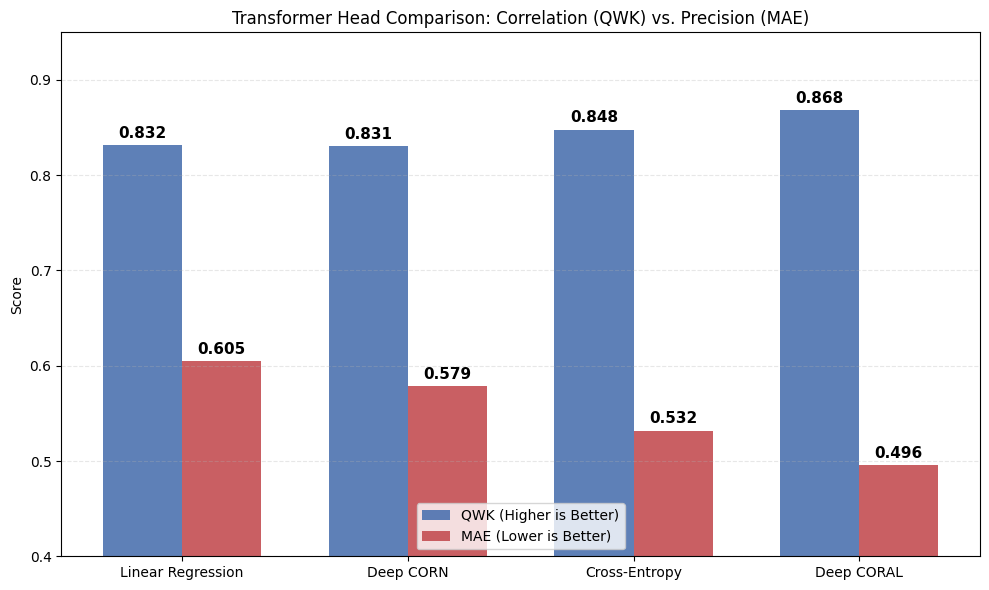

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your Final 5-Fold CV Results
models = ['Linear Regression', 'Deep CORN', 'Cross-Entropy', 'Deep CORAL']

# extracted from your provided text
qwk_scores = [0.832, 0.831, 0.848, 0.868]
mae_scores = [0.605, 0.579, 0.532, 0.496]

x = np.arange(len(models))
width = 0.35

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars
rects1 = ax.bar(x - width/2, qwk_scores, width, label='QWK (Higher is Better)', color='#4c72b0', alpha=0.9)
rects2 = ax.bar(x + width/2, mae_scores, width, label='MAE (Lower is Better)', color='#c44e52', alpha=0.9)

# Labels and Title
ax.set_ylabel('Score')
ax.set_title('Transformer Head Comparison: Correlation (QWK) vs. Precision (MAE)')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend(loc='lower center')

# Adjusted Y-limit to fit the new data range (MAE drops to ~0.49)
ax.set_ylim(0.4, 0.95)
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Add number labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()
# plt.savefig('deep_models_barchart.png', dpi=300)

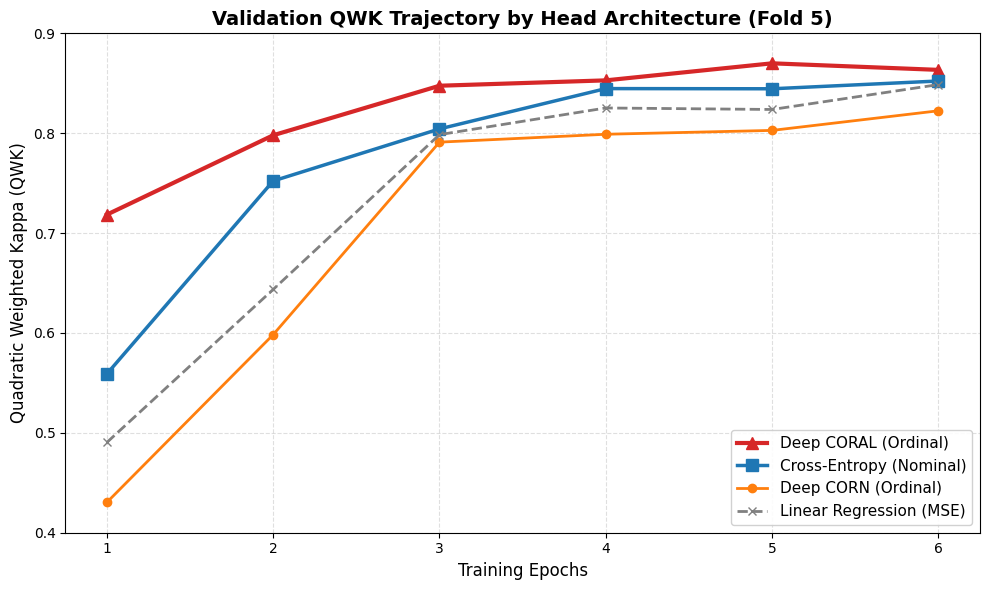

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# 1. Data Entry (Extracted from your tables)
# ==========================================
epochs = [1, 2, 3, 4, 5, 6]

# XLM-R + Deep CORAL (Fold 5)
coral_qwk = [0.718478, 0.797939, 0.847529, 0.852910, 0.869978, 0.863409]

# XLM-R + Cross-Entropy (Fold 5)
ce_qwk = [0.559005, 0.752201, 0.804305, 0.844673, 0.844489, 0.852275]

# XLM-R + Deep CORN (Fold 5)
corn_qwk = [0.430394, 0.598298, 0.791060, 0.798954, 0.802807, 0.822454]

# XLM-R + Linear Regression (Fold 5)
linreg_qwk = [0.490390, 0.643570, 0.798575, 0.825266, 0.823762, 0.848681]

# ==========================================
# 2. Plotting
# ==========================================
plt.figure(figsize=(10, 6))

# Plot Lines
# CORAL: Bold Red (The Winner/Fastest)
plt.plot(epochs, coral_qwk, marker='^', markersize=8, linewidth=3,
         color='#d62728', label='Deep CORAL (Ordinal)')

# Cross-Entropy: Bold Blue (The Runner Up)
plt.plot(epochs, ce_qwk, marker='s', markersize=8, linewidth=2.5,
         color='#1f77b4', label='Cross-Entropy (Nominal)')

# Deep CORN: Orange (Good but slower start)
plt.plot(epochs, corn_qwk, marker='o', markersize=6, linewidth=2,
         color='#ff7f0e', linestyle='-', label='Deep CORN (Ordinal)')

# Linear Regression: Gray Dashed (The Baseline behavior)
plt.plot(epochs, linreg_qwk, marker='x', markersize=6, linewidth=2,
         color='gray', linestyle='--', label='Linear Regression (MSE)')

# ==========================================
# 3. Styling & Annotations
# ==========================================
plt.title('Validation QWK Trajectory by Head Architecture (Fold 5)', fontsize=14, fontweight='bold')
plt.xlabel('Training Epochs', fontsize=12)
plt.ylabel('Quadratic Weighted Kappa (QWK)', fontsize=12)

# Legend location
plt.legend(loc='lower right', fontsize=11, frameon=True, fancybox=True, framealpha=0.9)

# Grid
plt.grid(True, linestyle='--', alpha=0.4)

# Axis limits to make it look clean
plt.ylim(0.4, 0.9)
plt.xticks(epochs)

# Optional: Annotate the fast start of CORAL
# plt.annotate('Fastest Convergence', xy=(1, 0.718), xytext=(1.5, 0.65),
#              arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
#              fontsize=10, fontweight='bold', color='#d62728')

plt.tight_layout()
plt.show()
# plt.savefig('combined_learning_curves.png', dpi=300)

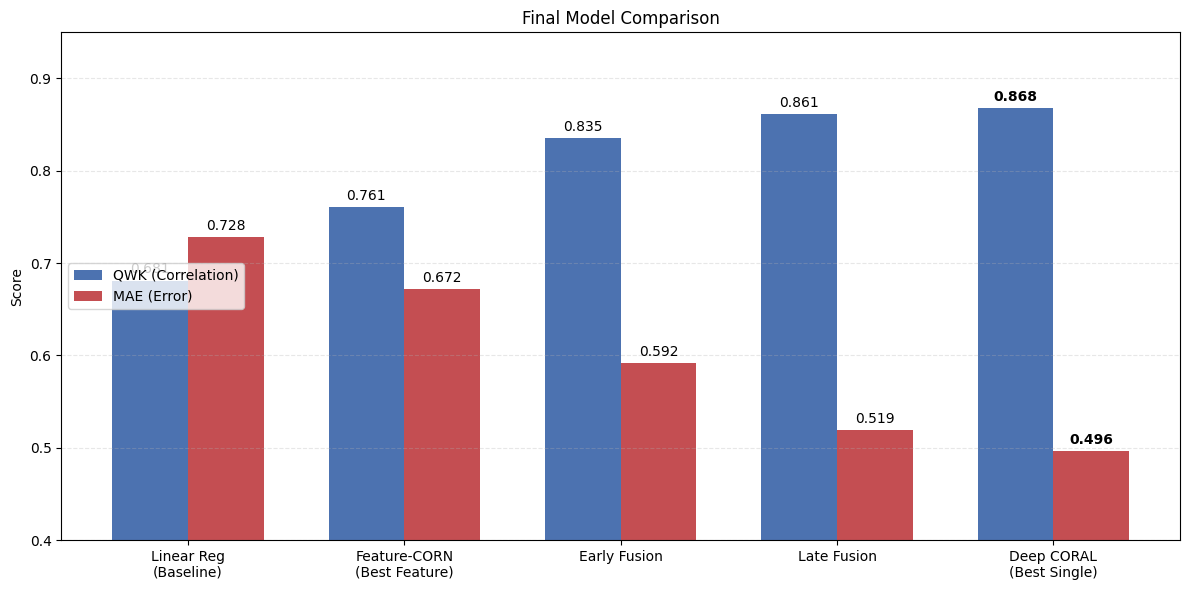

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your final results
models = ['Linear Reg\n(Baseline)', 'Feature-CORN\n(Best Feature)', 'Early Fusion', 'Late Fusion', 'Deep CORAL\n(Best Single)']
qwk_scores = [0.681, 0.761, 0.835, 0.861, 0.868]
mae_scores = [0.728, 0.672, 0.592, 0.519, 0.496]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

# Bars
rects1 = ax.bar(x - width/2, qwk_scores, width, label='QWK (Correlation)', color='#4c72b0')
rects2 = ax.bar(x + width/2, mae_scores, width, label='MAE (Error)', color='#c44e52')

# Labels
ax.set_ylabel('Score')
ax.set_title('Final Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend(loc='center left')
ax.set_ylim(0.4, 0.95)
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Add value labels
def autolabel(rects, is_mae=False):
    for rect in rects:
        height = rect.get_height()
        # Bold the best scores
        weight = 'bold' if (height == max(qwk_scores) and not is_mae) or (height == min(mae_scores) and is_mae) else 'normal'
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight=weight)

autolabel(rects1, is_mae=False)
autolabel(rects2, is_mae=True)

plt.tight_layout()
plt.show()
# plt.savefig('final_leaderboard.png', dpi=300)